# Group 2: Phase 1 - Cats vs Dogs Detector (CaDoD)

## Team Members

* Ben Perkins
* Lauren Madar
* Mangesh Walimbe
* Samin Barghan

## Project Abstract

TODO: Replace with Samin's edit

The task of classifying images is currently fertile ground for research in the area of computer vision and deep learning. One of the fundamental tasks involved is that of object detection within the images. A so-called ‘bounding box’ is drawn which gives the algorithm used a rectangular area to work with, as opposed to the much more unbounded irregular areas of a natural object. In order to predict these bounding boxes, our team will implement a Linear Regression model with gradient descent to achieve convergence. The task of classifying the given images as ‘Cat’ or ‘Dog’ will be handled at first by a Logistic Regression model. This will arrive at predictions via stochastic gradient descent, primarily because of the large size of the data. This will allow for a very good fit, but in a much less resource-intensive manner than with standard gradient descent. Both models will be evaluated by Average Precision, which is a standard metric for image classification. Additionally, both CXE and MSE will be used as well. We also plan to implement a confusion matrix and the Area Under Curve based on the Precision and Recall metrics, as these are often used to estimate how well a model performs. Our pipeline will include both column and image transformers, feature engineering for numeric data, and a regression pipeline.

## Project Description

The purpose of this project is create an end to end pipeline in machine learning to create an object detector for cats and dogs. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, take their RGB intensity values and flatten them from a 3D array to 2D. Then we will feed this array into a linear classifier and a linear regressor to predict labels and bounding boxes.

## Data Description

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

Identifying columns: ImageID, Source, LabelName, Confidence

Dimensional and positional columns: XMin, XMax, YMin,YMax, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y

Bounding box and image descriptive columns: IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside

When we look at a few random images, we can see that the photos vary in color and have different shapes and sizes. Also, we can see a photo with both a cat and dog, with the cat being barely visible (bottom row middle) so this shows any classifier fit on this type of photos will have to be robust.

![Sample Images](https://iu.instructure.com/users/6469957/files/119176770/preview?verifier=vwgzljiRpIRlNhVQK4aPqNwqrlygkVDkhnAhSrNf)

The first step to prepare data must be to standardize the images. Photos will have to be reshaped before modeling so that all images have the same shape and size. One approach we may use would be to load all photos and look at the distribution of the photo widths and heights then determine a new image size that fits the majority of the images. Smaller size allows a model to train more quickly. Another approach would be to start with a fixed size of 200x200 pixels. We can also filter color images to determine where the majority or highest density of each color pixel lies within the image.

The metadata contained in the csv file will need to be matched to each image file, and during Exploratory Data Analysis, we will determine relationships between any of the columns using pandas. For example, how many images contain more than one cat or dog (IsGroupOf)? How many of those images have IsOccluded, IsTruncated, IsInside? Can we determine if the bounding box of one object is larger than the other in order to guess the ‘main’ object? This will drive creation of additional features.

The code and project files are stored in a GitHub repository: i526Sp21Group2 (SEE PDF). We will impute missing data and document the strategy used, if needed (depending on the results of EDA). NumPy DataFrames embedded in our project Jupyter Notebook will track our exploration and transformation of data and engineering of any features ahead of training and fitting. Other Python libraries may be used for visualizations and will be documented.

In [1]:
from collections import Counter
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import tarfile

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings


# Import Data

### Unarchive data

Place the cadod.tar.gz into the same folder as this notebook. We've already extracted the files into the ./data folder (to prevent committing the large gz file to github).

In [2]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [3]:
path = 'data/cadod/'

#extract_tar('cadod.tar.gz', path) #uncomment this line if you need to extract the gzip.

### Load bounding box meta data

The metadata in the CSV file is for training for the bounding box prediction only.

In [4]:
df = pd.read_csv('data/cadod.csv')

In [5]:
df.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick  /m/0bt9lr           1  0.165000  0.903750   
1  0000cb13febe0138  xclick  /m/0bt9lr           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick  /m/0bt9lr           1  0.094167  0.611667   
3  0006303f02219b07  xclick  /m/0bt9lr           1  0.000000  0.999219   
4  00064d23bf997652  xclick  /m/0bt9lr           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.268333  0.998333           1            1  ...            0         0   
1  0.000000  0.999062           1            1  ...            0         0   
2  0.055626  0.998736           1            1  ...            0         0   
3  0.000000  0.998824           1            1  ...            0         0   
4  0.000000  0.694286           0            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.636250  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333   
1  0.312500  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062   
2  0.487500  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736   
3  0.508594  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000   
4  0.678038  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286   

   XClick4Y  
0  0.661667  
1  0.999062  
2  0.305942  
3  0.998824  
4  0.694286  

[5 rows x 21 columns]

# Exploratory Data Analysis

## Statistics

In [6]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")

There are a total of 12966 images


In [7]:
print(f"The total size is {os.path.getsize(path)/1000} MB")

The total size is 415.04 MB


In [8]:
df.shape

(12966, 21)

Replace `LabelName` with human readable labels

In [9]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)

In [10]:
df.LabelName.value_counts()

dog    6855
cat    6111
Name: LabelName, dtype: int64

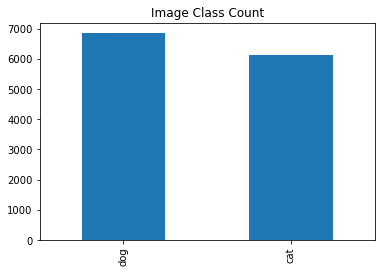

In [11]:
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [24]:
df.describe()

Confidence          XMin          XMax          YMin          YMax  \
count     12966.0  12966.000000  12966.000000  12966.000000  12966.000000   
mean          1.0      0.099437      0.901750      0.088877      0.945022   
std           0.0      0.113023      0.111468      0.097345      0.081500   
min           1.0      0.000000      0.408125      0.000000      0.451389   
25%           1.0      0.000000      0.830625      0.000000      0.910000   
50%           1.0      0.061250      0.941682      0.059695      0.996875   
75%           1.0      0.167500      0.998889      0.144853      0.999062   
max           1.0      0.592500      1.000000      0.587088      1.000000   

         IsOccluded   IsTruncated     IsGroupOf   IsDepiction      IsInside  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.464754      0.738470      0.013651      0.045427      0.001157   
std        0.499239      0.440011      0.118019      0.209354      0.040229   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           XClick1X      XClick2X      XClick3X      XClick4X      XClick1Y  \
count  12966.000000  12966.000000  12966.000000  12966.000000  12966.000000   
mean       0.390356      0.424582      0.494143      0.506689      0.275434   
std        0.358313      0.441751      0.405033      0.462281      0.415511   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.221293      0.096875      0.285071      0.130000      0.024323   
50%        0.435625      0.415625      0.531919      0.623437      0.146319   
75%        0.609995      0.820000      0.787500      0.917529      0.561323   
max        0.999375      0.999375      1.000000      0.999375      0.999375   

           XClick2Y      XClick3Y      XClick4Y  
count  12966.000000  12966.000000  12966.000000  
mean       0.447448      0.641749      0.582910  
std        0.401580      0.448054      0.403454  
min       -1.000000     -1.000000     -1.000000  
25%        0.218333      0.405816      0.400000  
50%        0.480838      0.825000      0.646667  
75%        0.729069      0.998042      0.882500  
max        0.999375      1.000000      0.999375

## Sample of Images

By plotting random samples of the images along with the bounding boxes and XClick points, we see that every image has a bounding box but not every image has valid (positive) XClick information. From the descriptions on the CaDoD site, the bounding boxes were either derived from the extreme points clicked (aka XClick) by a human, or provided in some other way (prediction or manually drawn as a box). 

Further, it seems that the XClick items follow no system. For example, they are not in a predictable clockwise or counterclockwise ordering, they do not seem to start on a particular edge (like left side vs right side).

Since the bounding box information is more widely available and, where XClick is present, bounding box is derived from XClick, we can drop the XClick feature later on and just focus more on examining the bounding box attributes.

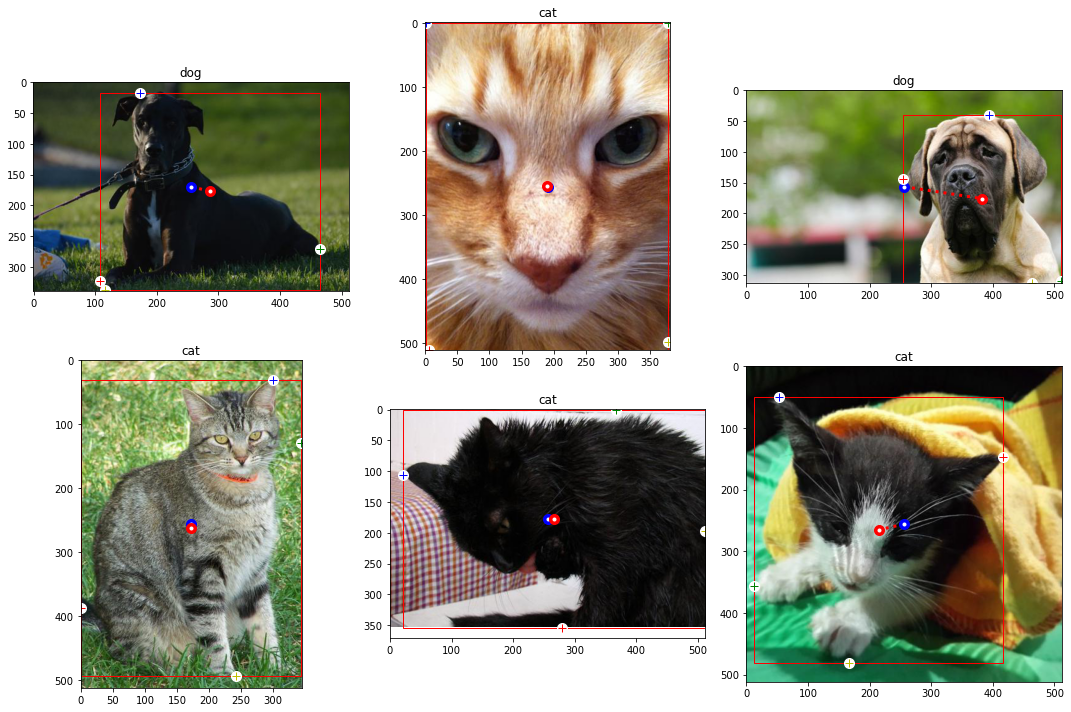

In [26]:
# plot random 6 images (original size)
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + df.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    xclick_xcoords = df.iloc[j,13:17]*w
    xclick_ycoords = df.iloc[j,17:21]*h
    
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
    ax[i].imshow(img)
    ax[i].set_title(df.LabelName[j])
    
    # Plot the bounding box as a red border
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')
    
    # If this image has valid positive XClick coords, plot those points
    if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
        print("cannot plot, invalid (negative) xclick!")
    else :
        # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)
        
plt.tight_layout()
plt.show()

Let's look at the IsDepiction column.  This seems to indicate if the image is a depiction (drawing, painting, not a 'real' animal photo).

In [27]:
depictioncount = Counter(df.IsDepiction)
depictioncount

Counter({0: 12371, 1: 592, -1: 3})

There are 3 items with -1 values. Let's look at those images to see what they're like.

In [28]:
df[df.IsDepiction < 0]

### Let's look at the 3 images with IsDepiction = -1

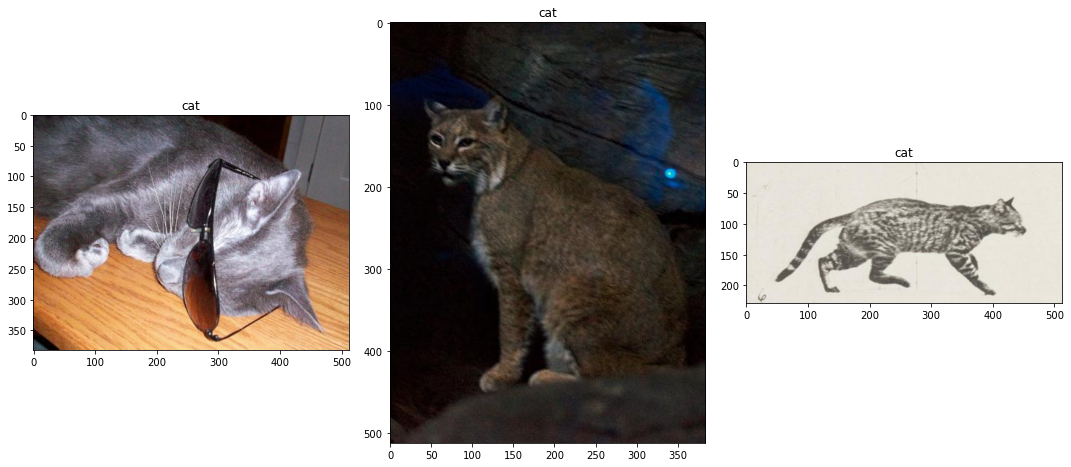

In [30]:
# plot 3 "IsDepiction" = -1 images.
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()
depictionimgs = df[df.IsDepiction < 0].to_numpy()
iterax = 0
for item in depictionimgs:
    img = mpimg.imread(path + item[0] + '.jpg')
    ax[iterax].imshow(img)
    ax[iterax].set_title(item[2])
    iterax += 1
plt.tight_layout()
plt.show()

Well, it looks from the dataframe above that these 3 images from Source = "activemil" don't have any XClick info or other info, though they do have bounding boxes.  These are NOT depictions/drawings though, so we can look for -1 values to clean up in our Feature Engineering stage.

What else can we tell from this?  Let's see if there is any other -1 data to deal with.

In [31]:
occludecount = Counter(df.IsOccluded)
truncatecount = Counter(df.IsTruncated)
groupcount = Counter(df.IsGroupOf)
insidecount = Counter(df.IsInside)
print (occludecount, truncatecount, groupcount, insidecount)

Counter({0: 6934, 1: 6029, -1: 3}) Counter({1: 9578, 0: 3385, -1: 3}) Counter({0: 12783, 1: 180, -1: 3}) Counter({0: 12945, 1: 18, -1: 3})


Gladly, this tells us that the same 3 images have -1 data, but others are ok (using either 0 or 1 for the IsOccluded, IsTruncated, IsGroupOf or IsInside columns.

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [32]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))
img_format = []
for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    imgratio = img.size[0]/img.size[1]
    if imgratio > 1 :
        img_format.append('landscape')
    elif imgratio < 1:
        img_format.append('portrait')
    else:
        img_format.append('square')
    img_size[i] += os.path.getsize(file)
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [36]:

img_shape_count = Counter(img_shape)
img_format_count = Counter(img_format)
img_format_count

Counter({'landscape': 9657, 'square': 1216, 'portrait': 2093})

In [37]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])
img_df.shape

(594, 2)

In [38]:
# create a dataframe for simple image aspect ratios
img_ratio_df = pd.DataFrame(set(img_format_count.items()), columns=['aspect_ratio','img_count'])
img_ratio_df.head()

aspect_ratio  img_count
0     portrait       2093
1    landscape       9657
2       square       1216

There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a count less than 100 and put that in a category called `other`

In [39]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [40]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [41]:
img_df.img_count.sum() == df.shape[0]

True

## Depiction Images

Now, let's look at a random sample of images marked as "Depictions" (IsDepiction = 1). This would indicate a drawing or other nonstandard image representation of a dog or cat and we need to verify this assumption.

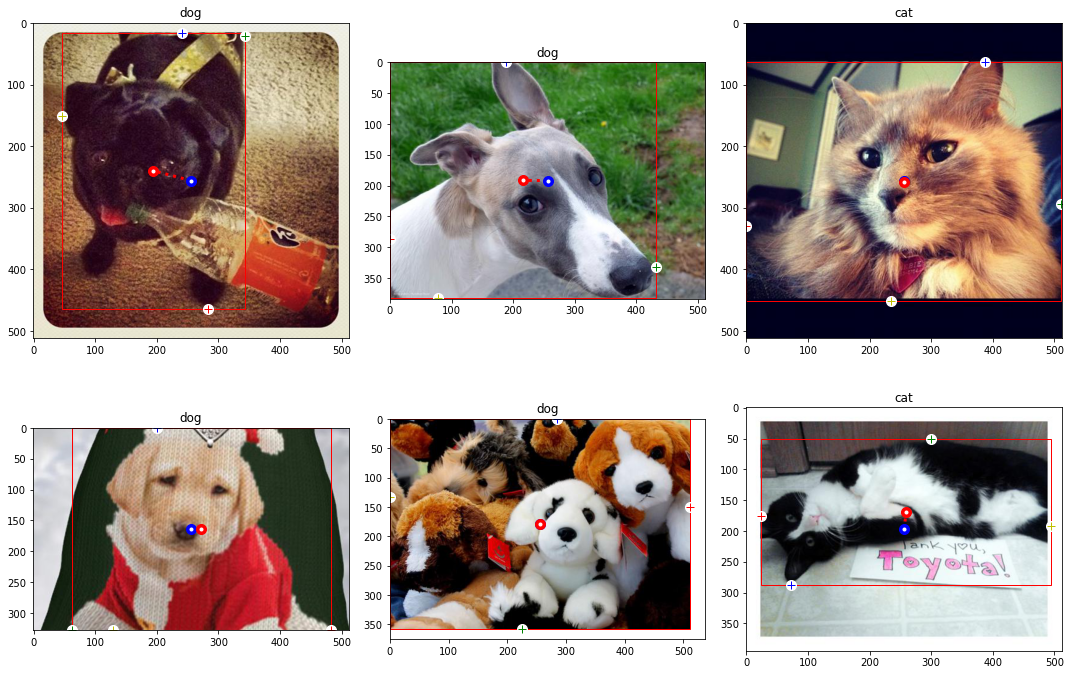

In [42]:
# Now let's look at a random sample of the "depiction" images.

# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

depictionitems = df[df["IsDepiction"] > 0]


for i,j in enumerate(np.random.choice(depictionitems.shape[0], size=6, replace=False)):
    img = mpimg.imread(path + depictionitems.ImageID.values[j] + '.jpg')
    h, w = img.shape[:2]
    coords = depictionitems.iloc[j,4:8]
    xclick_xcoords = depictionitems.iloc[j,13:17]*w
    xclick_ycoords = depictionitems.iloc[j,17:21]*h
    
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
    ax[i].imshow(img)
    ax[i].set_title(depictionitems.LabelName.values[j])
    
    # Plot the bounding box as a red border
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')
    
    # If this image has valid positive XClick coords, plot those points
    if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
        print("cannot plot, invalid (negative) xclick!")
    else :
        # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
        ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
        ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
        ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
        ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)
        
plt.tight_layout()
plt.show()

Well, it doesn't seem like IsDepiction tells us a whole lot.  Sometimes, IsDepiction is set to 1 for paintings, statues, or just 'heavily filtered' or artistically distorted photos, but also photos that have low light or are black and white are tagged with this feature.

## Plot aspect ratio

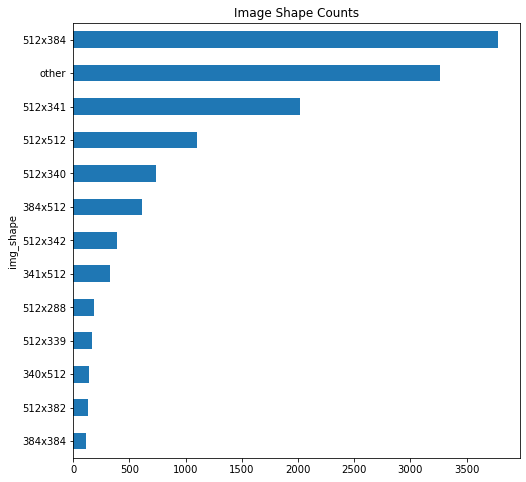

In [43]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

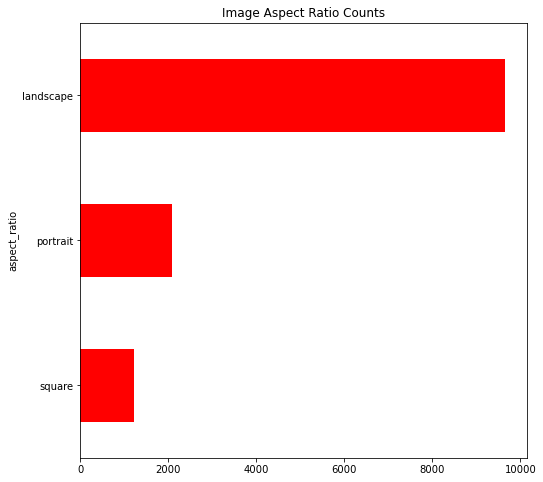

In [44]:
img_ratio_df.sort_values('img_count', inplace=True)
img_ratio_df.plot(x='aspect_ratio', y='img_count', kind='barh', color='red', figsize=(8,8), legend=False)
plt.title('Image Aspect Ratio Counts')
plt.show()

In [143]:
# convert to megabytes
img_size = img_size / 1000

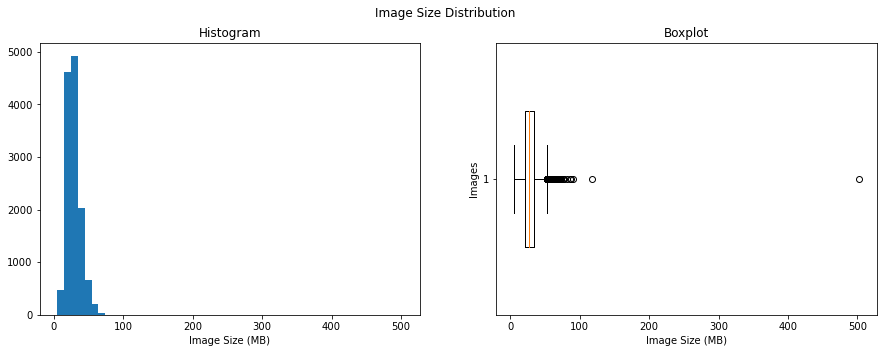

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

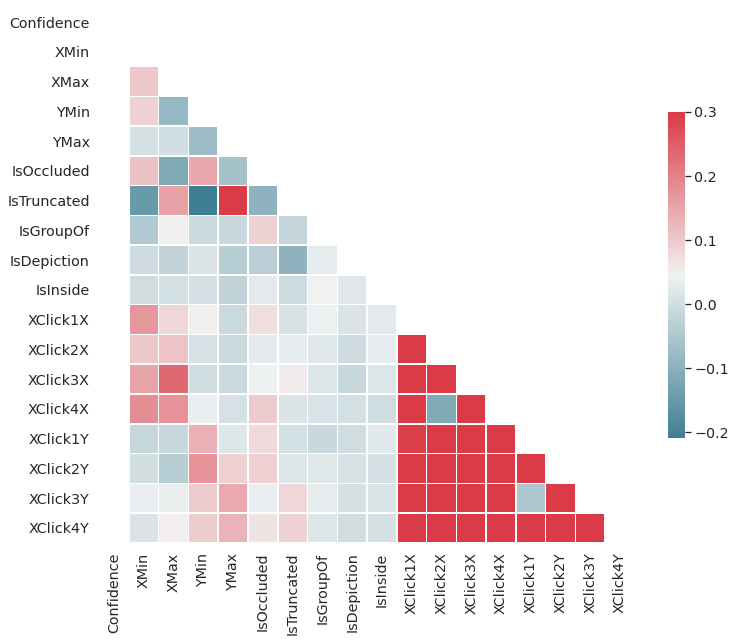

In [60]:
# data correlation LLM
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = df.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Preprocess

## Rescale the images

This rescaling will resize (and deform) all images to the same dimensions, 128 wide by 128 high.  The bounding box information in the CSV file are based on percentages and not pixel locations, so bounding box info is already normalized.  The rescaling of images to 128x128 in effect normalizes the image data so that we can better compare bounding boxes and images on the same dimensions without having to do further transformations.

In [145]:
!mkdir -p images/resized

In [146]:
%%time
# resize image and save, convert to numpy

img_arr = np.zeros((df.shape[0],128*128*3)) # initialize np.array

for i, f in enumerate(tqdm(df.ImageID)):
    img = Image.open(path+f+'.jpg')
    img_resized = img.resize((128,128))
    img_resized.save("images/resized/"+f+'.jpg', "JPEG", optimize=True)
    img_arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 2min 24s, sys: 16.4 s, total: 2min 41s
Wall time: 11min 7s


Plot the resized and filtered images

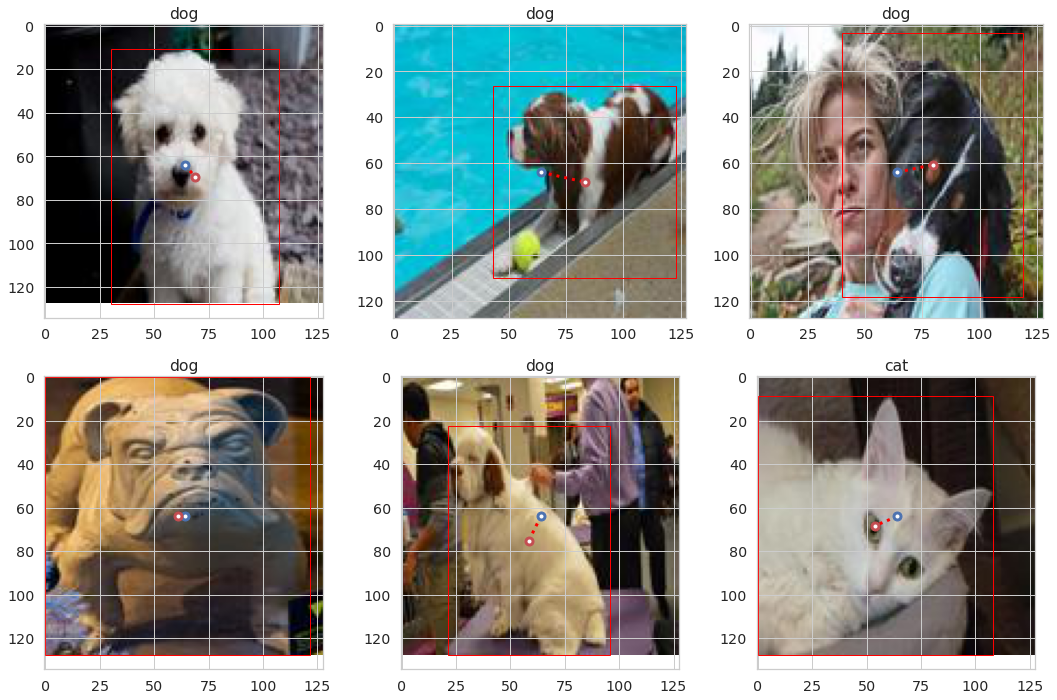

In [78]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(df.shape[0], size=6, replace=False)):
    #imgpath = path+'resized/'+df.ImageID.values[j]+'.jpg' #this was looking in data/cadod/resized which didn't exist
    imgpath = 'images/resized/'+df.ImageID.values[j]+'.jpg'
    img = mpimg.imread(imgpath)
    h, w = img.shape[:2]
    coords = df.iloc[j,4:8]
    centerimg = [w/2, h/2]
    centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    ax[i].imshow(img)
    ax[i].set_title(df.iloc[j,2])
    ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    # Plot the center of the image (will always be at (64,64) in green and white) and the center of the bounding box in red and white.
    ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
    ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
    ax[i].plot(centerimg[0], centerimg[1],'w.')
    ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
    ax[i].plot(centerbox[0], centerbox[1],'w.')

plt.tight_layout()
plt.show()

In [12]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Checkpoint and Save data

In [13]:
mkdir -p data

In [14]:
# Skip/comment out the following steps if you've already exported the data as it takes a while.
# np.save('data/img.npy', img_arr.astype(np.uint8), allow_pickle=True)
# np.save('data/y_label.npy', df.Label.values, allow_pickle=True)
# np.save('data/y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32), allow_pickle=True)

# Feature Engineering

From our EDA and understanding of our model flow, we see that we can only depend on having XMin, YMin, XMax and YMax as an output from our Localization prediction.

We can engineer some features from the training data examples of these bounding box points by determining the width percentage and height percentage that the bounding box takes up of the whole image space, and then determining the centerpoint of bounding box. We can also determine if the bounding box shares one or more edges (top, bottom, left or right) with the image boundaries.

In [74]:


#--------------------------------------------------
# Feature engineering
#--------------------------------------------------
# Derive the area features
class ImDimFeatures(BaseEstimator, TransformerMixin):
    """derive the image dimension features from the length and width features
       RETURNS
           a dataframe with all input columns + new columns describing image file
    """
    def __init__(self, ):
        pass
        
    def fit(self, X, y=None):
        # stateless transformer that does not depend on the data
        # it is a simple formula that is provided upfront: area = length x height
        return self
    
    def transform(self, X):
        # always copy the input frame - we don't want to impact the original frame in place
        # note here that transformed images are all 128x128 (normalized) so ignore img ratio
        
        self.col_names = [  "bbox_w_percent",
                            "bbox_h_percent",
                            "bbox_area",
                            "bbox_centerX",
                            "bbox_centerY",
                            "num_touch_edges",
                            "bb_touch_top",
                            "bb_touch_left",
                            "bb_touch_right",
                            "bb_touch_bottom"]
        X = pd.DataFrame(data=X.copy(), columns=["XMin", "YMin", "XMax", "YMax"])
        X.append(self.col_names)
        
        # we can ignore XClick items as those are extreme points of the object and just contribute to XMin/Xmax YMin/Ymax which is the actual box.
        # XMin/Max and YMin/Max are NORMALIZED (out of 1.0) and so are percentages of the full image size.
        
        # XMax - XMin is the % width of the bounding box.
        X["bbox_w_percent"] = X["XMax"]-X["XMin"]
        
        # YMax - YMin is the % height of the bounding box.
        X["bbox_h_percent"] = X["YMax"]-X["YMin"]
        
        # Find centerpoint of bounding box.  Since we resized all images to 128x128, the centerpoint of the resized images will always be (64,64)
        X["bbox_centerX"] = (X["bbox_w_percent"]/2) + X["XMin"]
        X["bbox_centerY"] = (X["bbox_h_percent"]/2) + X["YMin"]
        
        X["bbox_area"]=X["bbox_w_percent"]*X["bbox_h_percent"]
        
        X["bb_touch_left"] = 1*(X["XMin"]==0)
        X["bb_touch_right"] = 1*(X["XMax"]==1)
        X["bb_touch_top"] = 1*(X["YMin"]==0)
        X["bb_touch_bottom"] = 1*(X["YMax"]==1)
        
        # The number of bounding box edges that share a side with the image boundary (top, bottom, left, right)
        X["num_touch_edges"] = X["bb_touch_left"]+X["bb_touch_right"]+X["bb_touch_top"]+X["bb_touch_bottom"]
        
        # We don't need XClick columns, Source column (since Confidence is filled to 1 for all).
     
        # Retain the XMin, YMin etc bounding box points as we'll need that to draw/validate bounding box predictions later.
        
        # Set -1 values to 0 for values like IsOccluded, IsDepiction, IsInside for those 3 activemil images we found earlier.
        X.replace(-1, 0, inplace=True)
        
        return X
    
    def get_feature_names(self):
        return self.col_names

In [75]:
#--------------------------------
# Test the are transformer  step on the csv data
#--------------------------------
display(df.head())

imdimfeatures = ImDimFeatures().fit(df)
display(imdimfeatures.transform(df).head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000b9fcba019d36  xclick       dog           1  0.165000  0.903750   
1  0000cb13febe0138  xclick       dog           1  0.000000  0.651875   
2  0005a9520eb22c19  xclick       dog           1  0.094167  0.611667   
3  0006303f02219b07  xclick       dog           1  0.000000  0.999219   
4  00064d23bf997652  xclick       dog           1  0.240938  0.906183   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsInside  XClick1X  \
0  0.268333  0.998333           1            1  ...         0  0.636250   
1  0.000000  0.999062           1            1  ...         0  0.312500   
2  0.055626  0.998736           1            1  ...         0  0.487500   
3  0.000000  0.998824           1            1  ...         0  0.508594   
4  0.000000  0.694286           0            0  ...         0  0.678038   

   XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  XClick4Y  Label  
0  0.903750  0.748750  0.165000  0.268333  0.506667  0.998333  0.661667      1  
1  0.000000  0.317500  0.651875  0.000000  0.410882  0.999062  0.999062      1  
2  0.611667  0.243333  0.094167  0.055626  0.226296  0.998736  0.305942      1  
3  0.999219  0.000000  0.478906  0.000000  0.375294  0.720000  0.998824      1  
4  0.906183  0.240938  0.522388  0.000000  0.370000  0.424286  0.694286      1  

[5 rows x 22 columns]

XMin      YMin      XMax      YMax  bbox_w_percent  bbox_h_percent  \
0  0.165000  0.268333  0.903750  0.998333        0.738750        0.730000   
1  0.000000  0.000000  0.651875  0.999062        0.651875        0.999062   
2  0.094167  0.055626  0.611667  0.998736        0.517500        0.943110   
3  0.000000  0.000000  0.999219  0.998824        0.999219        0.998824   
4  0.240938  0.000000  0.906183  0.694286        0.665245        0.694286   

   bbox_centerX  bbox_centerY  bbox_area  bb_touch_left  bb_touch_right  \
0      0.534375      0.633333   0.539288              0               0   
1      0.325937      0.499531   0.651264              1               0   
2      0.352917      0.527181   0.488059              0               0   
3      0.499609      0.499412   0.998044              1               0   
4      0.573561      0.347143   0.461870              0               0   

   bb_touch_top  bb_touch_bottom  num_touch_edges  
0             0                0                0  
1             1                0                2  
2             0                0                0  
3             1                0                2  
4             1                0                1

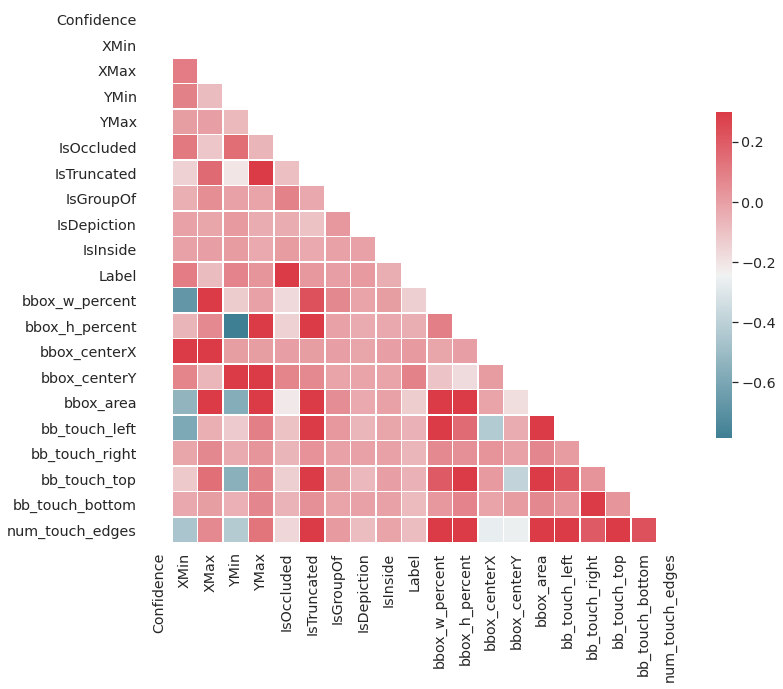

In [17]:
# data correlation on image dimension features LLM


sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = imdimfeatures.transform(df).corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Split Train and Test Datasets

## Load data

In [18]:
X = np.load('data/img.npy', allow_pickle=True, fix_imports=True)
y_label = np.load('data/y_label.npy', allow_pickle=True, fix_imports=True)
y_bbox = np.load('data/y_bbox.npy', allow_pickle=True, fix_imports=True)

In [19]:
idx_to_label = {1:'dog', 0:'cat'} # encoder

Double check that it loaded correctly

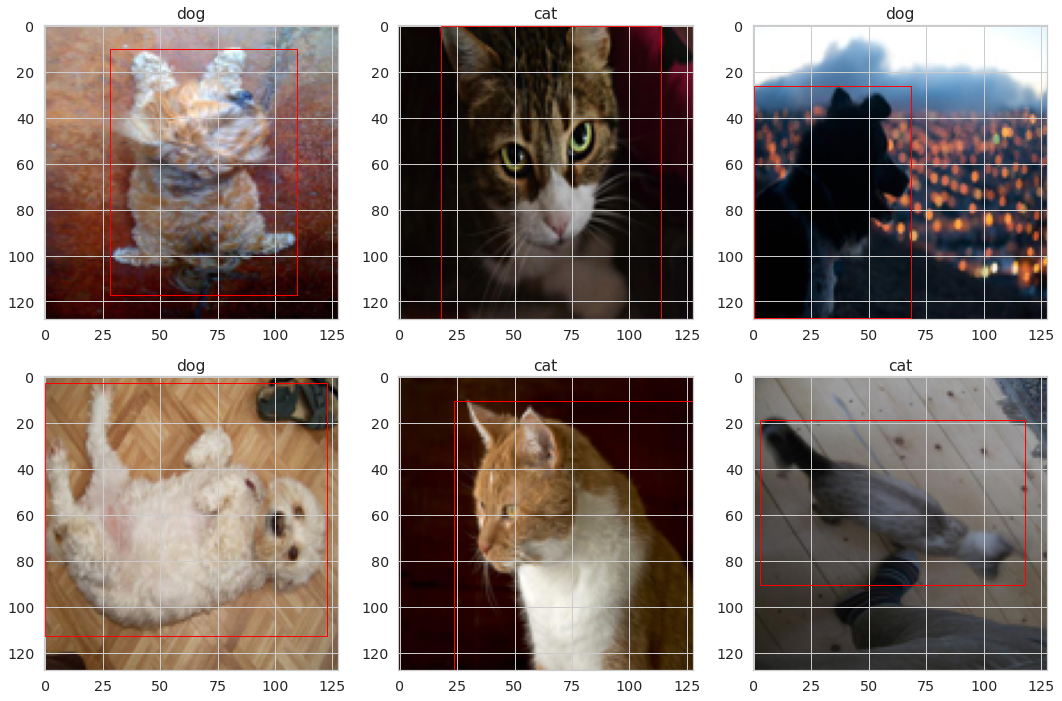

In [20]:
# plot random 6 images
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X.shape[0], size=6, replace=False)):
    coords = y_bbox[j] * 128
    ax[i].imshow(X[j].reshape(128,128,3))
    ax[i].set_title(idx_to_label[y_label[j]])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

## Table of results

We will track results of experiments in order to compare them for performance.

In [21]:
results = pd.DataFrame(columns=["Accuracy"])

### Split data

Create training and testing sets.

In [110]:
# X_train, X_test, y_train, y_test_label = train_test_split(X, y_label, train_size=0.1, random_state=27)

split_setting = 0.025 #used for our train/test split.  When done, set to 0.8 for train size.

# Split for the localization task
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_bbox, train_size=split_setting, random_state=27)

# Split for the classification task
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_label, train_size=split_setting, random_state=27)

# Don't touch that test data!

# TODO: later, adjust train size to 0.8 and reserve test of 0.2.
# TODO: what happens with predicted bbox data from test?  Well, still gets reserved to verify at the end.

# Baseline Localization (Bounding Box) Prediction Model in SKLearn

We chose to train a Linear Regression model with `Lasso` to predict the bounding boxes. To classify the images we will train an instance of `LogisticRegression` after applying the `StandardScaler` to the data.

We will compare 'Lasso' with 'Ridge' regression to see which performs better.

We decided not to go with SGDClassifier as originally proposed, as we'll only be fitting image data to the localization model, and saving other data attributes for the classifier.  

TODO: delete if needed:
{We're choosing `SGDClassifier` because the data is large and I want to be able to perform stochastic gradient descent and also its ability to early stop. With this many parameters, a model can easily overfit so it's important to try and find the point of where it begins to overfit and stop for optimal results.}

## Regression Models

### Lasso model

For localization prediction.

In [23]:
lasso_model = Lasso()
#lasso_params = {'alpha':[1e-3, 1e-2, 1e-1, 1, 10]}
#gs_Lasso = GridSearchCV(lasso_model, lasso_params, cv=5, n_jobs=-1)

### Ridge Regression model

To try as an alternative to Lasso. Unclear which would predict boxes better.

In [24]:
# Ridge regression with grid search cv

ridge_model = Ridge()
#ridge_params = {'alpha':[1e-3, 1e-2, 1e-1, 1, 10]}
#gs_ridge = GridSearchCV(ridge_model, ridge_params, cv=5, n_jobs=-1)

### KNN model

To try as an alternative to the Regression models. 

In [28]:
# K Nearest Neighbors

knn_model = KNeighborsRegressor()

## GridSearchCV on Localization Models and Hyperparameters

Rather than running GridSearchCV on each model to see which alpha params to use, let's instead use an Estimator Selection Helper (thanks to http://www.davidsbatista.net/blog/2018/02/23/model_optimization/ )

In [30]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [31]:
# Localization parameters

# Instead of running GridSearchCV twice on two separate models, let's run it once on both models and compare the performance.
models_local = {
    'lasso_model': lasso_model,
    'ridge_model': ridge_model,
    # And hey, why not add KNN to the mix as well?
    'knn_model': knn_model
}

params_local = {
    'lasso_model': {'alpha':[1e-1, 1, 10, 100]},
    'ridge_model': {'alpha':[1e-1, 1, 10, 100]},
    'knn_model': {'n_neighbors':[3,5,10]}
}

local_helper = EstimatorSelectionHelper(models_local, params_local)
local_helper.fit(X_train_box, y_train_box, cv=5, n_jobs=12, verbose=1) # use n_jobs=-1 if you can.

# Pipeline creation: LLM working
#classification_pipeline = Pipeline(    #A pipeline for cat/dog classification predictions.
#    [('scaler', StandardScaler()),
#    ('classifier', LogisticRegression())])

#Full_pipeline = FeatureUnion([('class', classification_pipeline),('local', localization_pipeline)]) 

# Create a transformer to label the images as portrait, landscape, or square?
# Look at img_shape in img_df - it is WxH which we can split on x to get numeric width and numeric height.
# we can store w and h, and also determine ratio: w/h > 1 = landscape, w/h < 1 = portrait, w/h = 1 = square

Running GridSearchCV for lasso_model.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:  1.4min remaining:    9.1s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Running GridSearchCV for ridge_model.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    2.7s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Running GridSearchCV for knn_model.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:   17.6s remaining:   15.4s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:   25.9s finished


In [57]:
# what is the best estimator and other score info?
localization_gridsearch_summary = local_helper.score_summary()
localization_gridsearch_summary.head()

lasso_model
ridge_model
knn_model


estimator min_score mean_score max_score std_score alpha n_neighbors
2   lasso_model -0.043594  -0.018593 -0.004509  0.013669    10         NaN
3   lasso_model -0.043594  -0.018593 -0.004509  0.013669   100         NaN
1   lasso_model -0.080302  -0.035479  -0.00949  0.027341     1         NaN
10    knn_model -0.141258  -0.094803 -0.042158  0.032219   NaN          10
9     knn_model -0.276265  -0.186063 -0.112204  0.063881   NaN           5

In [58]:
winning_model = localization_gridsearch_summary.iloc[0].estimator
winning_alpha = localization_gridsearch_summary.iloc[0].alpha

print("The localization model that will be used is ", winning_model, " with alpha = ", winning_alpha)

The localization model that will be used is  lasso_model  with alpha =  10


## Localization Model Winner

We have our winning localization model, which is Lasso with alpha = 10.

Add it to a pipeline!

In [96]:
localization_pipeline = Pipeline([
    ('locate', Lasso(alpha=10))
])

# Classification Prediction Model (Homegrown Logistic Regression)

We will be using a Homegrown Logistic Regression model for our classification of the image data and bounding box data to a class label of cat or dog.

## Feature Engineering and the Classification pipeline

Earlier, we split a training set to X_train_class.
We need to pull in the bounding box data from y_train_box.  In our final pipeline, bounding box data will come from the prediction of the localization model, but for now, let's run our substeps to make sure the homegrown Classification model works.

First, take the y_train_box data and make sure that our Feature Transformer can deal with it.

In [97]:
# Lauren working - the Feature Transformer ImDimFeatures assumes a dataframe, it needs to handle numpy arrays too for XMin, XMax etc)
print(y_train_box)

display(ImDimFeatures().transform(y_train_box).head())


[[0.       0.094139 0.999257 0.999112]
 [0.       0.250469 0.96125  0.999062]
 [0.       0.       0.890523 0.998366]
 ...
 [0.02125  0.       0.999375 0.927287]
 [0.041594 0.155093 0.993068 0.75    ]
 [0.06     0.       0.83     0.999066]]


XMin      YMin      XMax      YMax  bbox_w_percent  bbox_h_percent  \
0  0.000000  0.094139  0.999257  0.999112        0.999257        0.904973   
1  0.000000  0.250469  0.961250  0.999062        0.961250        0.748593   
2  0.000000  0.000000  0.890523  0.998366        0.890523        0.998366   
3  0.128125  0.013133  0.998125  0.999062        0.870000        0.985929   
4  0.001875  0.000000  0.998125  0.992958        0.996250        0.992958   

   bbox_centerX  bbox_centerY  bbox_area  bb_touch_left  bb_touch_right  \
0      0.499629      0.546625   0.904301              1               0   
1      0.480625      0.624766   0.719585              1               0   
2      0.445262      0.499183   0.889068              1               0   
3      0.563125      0.506097   0.857758              0               0   
4      0.500000      0.496479   0.989234              0               0   

   bb_touch_top  bb_touch_bottom  num_touch_edges  
0             0                0                1  
1             0                0                1  
2             1                0                2  
3             0                0                0  
4             1                0                1

In [34]:
# %%time
# model = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10, 
#                       early_stopping=True, validation_fraction=0.1, n_iter_no_change=3)
# # 0.2 validation TODO

# # Should we do cross fold validation here?
# model.fit(X_train, y_train)

In [ ]:
model.n_iter_

4

Did it stop too early? Let's retrain with a few more iterations to see. Note that `SGDClassifier` has a parameter called `validation_fraction` which splits a validation set from the training data to determine when it stops.

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

In [ ]:
# model2 = SGDClassifier(loss='log', n_jobs=-1, random_state=27, learning_rate='adaptive', eta0=1e-10)

# epochs = 30

# train_acc = np.zeros(epochs)
# valid_acc = np.zeros(epochs)
# for i in tqdm(range(epochs)):
#     model2.partial_fit(X_train, y_train, np.unique(y_train))
    
#     #log
#     train_acc[i] += np.round(accuracy_score(y_train, model2.predict(X_train)),3)
#     valid_acc[i] += np.round(accuracy_score(y_valid, model2.predict(X_valid)),3)

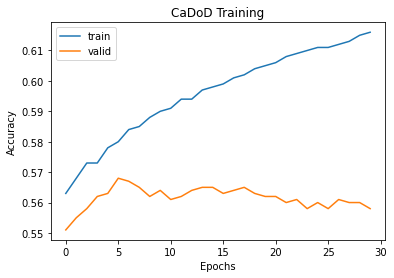

In [ ]:
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.title('CaDoD Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
del model2

### Fit models & Find Predictions

In [117]:
# train the localization model and get the predictions out of the training set to feed down the pipeline.

localization_pipeline.fit(X_train_box, y_train_box)

X_train_class = localization_pipeline.predict(X_train_box)



In [118]:
# transform the output of the localization pipeline with feature engineering

feature_pipeline = Pipeline(    #A pipeline for column transformation of bounding box data
    [('ImDimFeatures', ImDimFeatures())])

X_train_class_transformed = feature_pipeline.transform(X_train_class)
#curious? do X_train_class.head() to see a sample

In [119]:
# train the classification model with the transformed train-predictions 

classification_pipeline = Pipeline( #A pipeline for the logistic prediction classifier
    [('class', LogisticRegression())])

classification_pipeline.fit(X_train_class_transformed, y_train_class)

Pipeline(steps=[('class', LogisticRegression())])

In [ ]:
# All together now, run the whole pipeline set to predict.  DO NOT RUN THIS until ready as it's a large test set

# X_test_class = localization_pipeline.predict(X_test_box)
# X_test_class_transformed = feature_pipeline.transform(X_test_class)
# X_test_class_predictions = classification_pipeline.predict(X_test_class_transformed)

# Evaluation

In [ ]:
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train MSE", 
                               "Valid MSE",
                               "Test  MSE",
                               "Train F1",
                               "Valid F1",
                               "Test F1"
                              ])


### Confusion Matrices

A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm.


In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
exp_name = f"Baseline: Linear Locale Model, Lasso"
expLog.loc[0,:4] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, gs_lasso.predict(X_train)), 
                accuracy_score(y_valid, gs_lasso.predict(X_valid)),
                accuracy_score(y_test_label, gs_lasso.predict(X_test))],3))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """


In [ ]:
expLog

exp_name Train Acc Valid Acc Test  Acc Train MSE Valid MSE  \
0  Baseline: SGDClassifier     0.584     0.574     0.554       NaN       NaN   

  Test  MSE  
0       NaN

In [ ]:
expLogClass = pd.DataFrame(columns=["exp_name", 
                               "Train AP", 
                               "Valid AP",
                               "Test  AP",
                               "Train F1",
                               "Valid F1",
                               "Test F1"
                              ])

In [ ]:
exp_name = f"Image Classify: Logistic Regression"
expLogClass.loc[1,:10] = [f"{exp_name}"] + list(np.round([
    mean_average_precision(y_train, class_preds_train),
    mean_average_precision(y_valid, class_preds_valid),
    mean_average_precision(y_test, class_preds_test),
    f1_score(y_train, class_preds_train),
    f1_score(y_valid, class_preds_valid),
    f1_score(y_test, class_preds_test)
    
]))

In [ ]:
expLogClass

**Plot the Precision-Recall Curve of Logistic Regression Classifier**

In [ ]:
plot_precision_recall_curve(classification_pipeline, X_test, y_test, response_method='auto')

**Plot Confusion Matrix of Logistic Regression Classifier**

In [ ]:
plot_confusion_matrix(classifcation_pipeline, X_test, y_test, values_format='d', cmap=cmap)

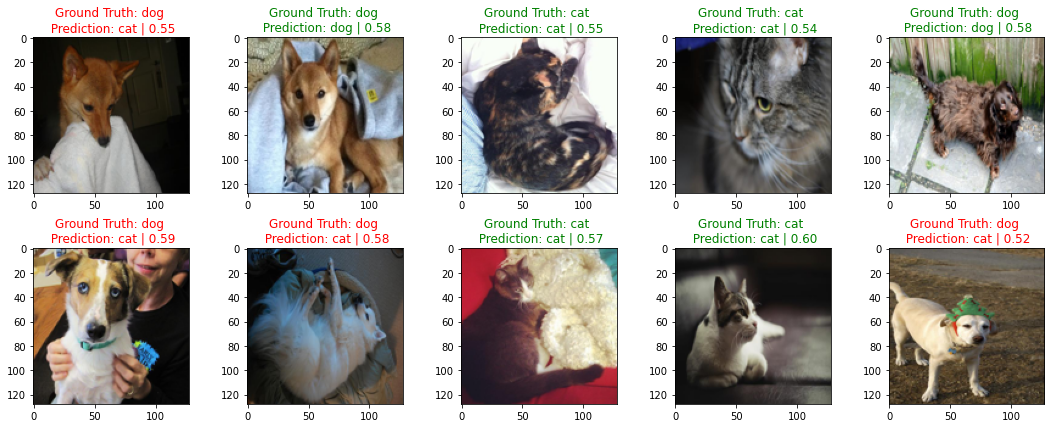

In [ ]:
y_pred_label = model.predict(X_test)
y_pred_label_proba = model.predict_proba(X_test)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False,figsize=(15,6))
ax = ax.flatten()

for i in range(10):
    img = X_test[i].reshape(128,128,3)
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[i]],
                                                                   idx_to_label[y_pred_label[i]],
                                                                   y_pred_label_proba[i][y_pred_label[i]]),
                   color=("green" if y_pred_label[i]==y_test_label[i] else "red"))

plt.tight_layout()
plt.show()

## Regression

### Split data

In [120]:
# We have data split higher up... not sure we need this - Lauren
#X_train, X_test, y_train, y_test = train_test_split(X, y_bbox, test_size=0.01, random_state=27)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=27)

### Train

In [ ]:
# Do we need this?  - Lauren

%%time

from sklearn.linear_model import LinearRegression
# TODO closed loop solution, could use Lasso Ridge
model = ..... #fill in 
model.fit(X_train, y_train)

# might take a few minutes to train
#CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
#Wall time: 17min 24s

CPU times: user 1h 26min 40s, sys: 5min 53s, total: 1h 32min 34s
Wall time: 17min 24s


LinearRegression(n_jobs=-1)

### Evaluation

In [ ]:
expLog.iloc[0,4:] = list(np.round([mean_squared_error(y_train, model.predict(X_train)), 
          mean_squared_error(y_valid, model.predict(X_valid)), 
          mean_squared_error(y_test, model.predict(X_test))],3))

expLog

exp_name Train Acc Valid Acc Test  Acc Train MSE Valid MSE  \
0  Baseline: Linear Model     0.584     0.574     0.554         0     0.036   

  Test  MSE  
0     0.035

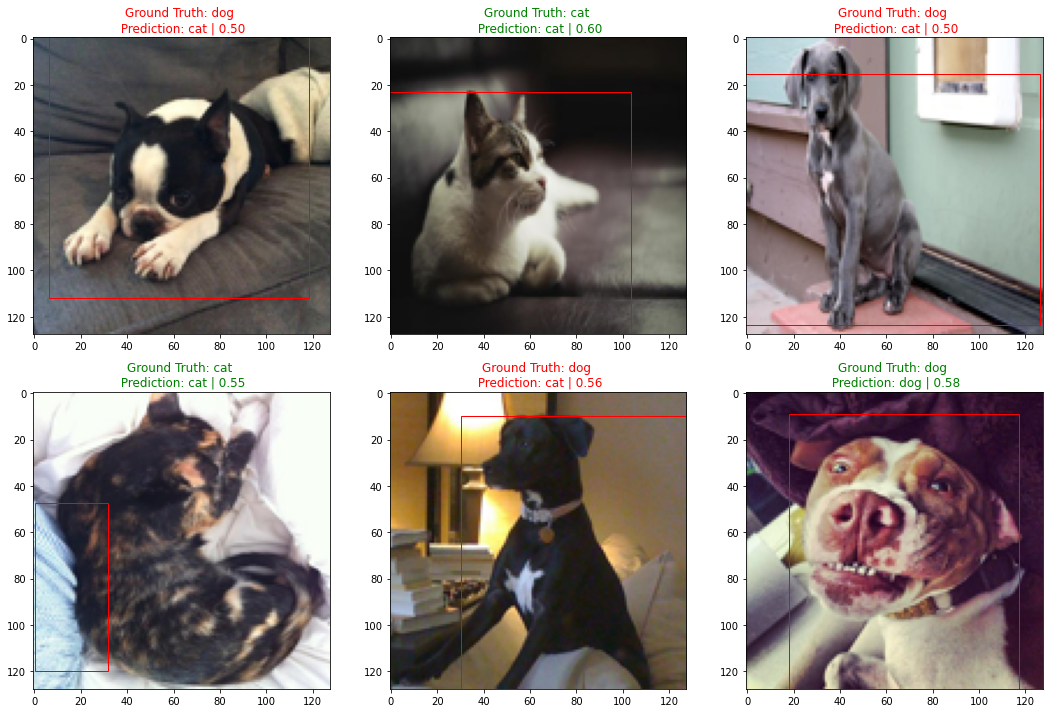

In [ ]:
y_pred_bbox = model.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()

for i,j in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    img = X_test[j].reshape(128,128,3)
    coords = y_pred_bbox[j] * 128
    ax[i].imshow(img)
    ax[i].set_title("Ground Truth: {0} \n Prediction: {1} | {2:.2f}".format(idx_to_label[y_test_label[j]],
                                                                   idx_to_label[y_pred_label[j]],
                                                                   y_pred_label_proba[j][y_pred_label[j]]),
                   color=("green" if y_pred_label[j]==y_test_label[j] else "red"))
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]), 
                                  coords[2]-coords[0], coords[3]-coords[1], 
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### Cross-Validation

In [160]:
#From Lab Unit-07-Linear_classifiers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

acc = None
cm = None
estimator = [LogisticRegression(), RandomForestClassifier()]

for e in estimator:
    for train_idx, test_idx in cv_idx:

        # split
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # create logistic regression pipeline
        model = Pipeline([('scaler', MinMaxScaler()),
                          ('classifier', e)])

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # evaluate

        if acc is None:
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred).astype(np.float32)
        else:
            acc += accuracy_score(y_test, y_pred)
            cm += confusion_matrix(y_test, y_pred)
        
# take the average value across all folds
acc /= cv.n_splits
cm /= cm.sum(axis=1)[:, np.newaxis]

NameError: name 'LogisticRegression' is not defined

In [ ]:
plt.figure(figsize=(10, 8))
g = sns.heatmap(cm, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("CV", fontsize=14);

## Gridsearch to optimize hyperparameter selection for classification

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__penalty':['l1','l2'], 
              'classifier__C': [1, 10, 100, 1000, 10000]
             }

gs = GridSearchCV(pipe_model, param_grid, cv=5, verbose=2)

classification_pipeline.named_steps['classifier']

gs.fit(X_train, y_train)

# best grid search parameters
gs.best_params_

# best estimator
s = gs.best_estimator_.named_steps['scaler']

# access logistic regression coefficients from best estimator
gs.best_estimator_.named_steps['classifier'].coef_

# Homegrown Implementation -- Not Tested Yet (4/19, 12:15PM)

Implement a Homegrown Logistic Regression model.

In [ ]:
class LogisticRegressionHomegrown(object):
    def __init__(self, tol=1e-2):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.tol = tol
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": [], 
                        "acc": []}
    # calculate gradient of objective function
    def _grad(self, X, y):
        # number of training examples
        n = X.shape[0]
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # error
        probs[range(n),y] -= 1
        # gradient
        gradient = np.dot(X.T, probs) / n 
        #gradient = np.dot(X.T, probs) / n + 2 *eta *np.sum(self._theta[1:,], by 1)
        return gradient
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha=0.05):
        for i in range(max_iter):
            #alternative stopping criteria based on the root satisfying FOC: gradient(W) eq  zeros
             # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            if np.max(np.abs(grad)) < self.tol: ## gradient(W) == [[0.0001,0.001,0.000001,0.0], [0.0001,0.001,0.000001,0.0]]
                print(f"finished after gradient after {i} iterations: via np.max(np.abs(grad)) < self.tol:")
                break
            theta_old = self._theta.copy()
            self.history["coef"].append(self._theta[1:])
            self.history["intercept"].append(self._theta[0])
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            # do gradient step
            self._theta -= alpha * grad
            # alternative stopping criteria based on the root estimate not changing
            if np.max(np.abs(theta_old - self._theta)) < self.tol: 
                print(f"finished after gradient after {i} iterations: via np.max(np.abs(theta_old - theta))")
                break
    # public API for fitting a linear regression model
    def fit(self, X, y, max_iter=1000):
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        # do full gradient descent
        self._gd(X, y, max_iter)
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
    # computes logloss and accuracy for (X, y)
    def score(self, X, y):
        # number of training samples
        n = X.shape[0]
        # get scores
        scores = self._predict_raw(X)
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        return metrics
    # computes scores for each class and each object in X
    def _predict_raw(self, X):
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        scores -= np.max(scores, axis=1, keepdims=True)
        return scores
    # predicts class for each object in X
    def predict(self, X):
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, plot_precision_recall_curve

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#from HomegrownLogisticRegression import LogisticRegressionHomegrown

%matplotlib inline
# iris = load_iris()
# X = pd.DataFrame(iris.data, columns=iris.feature_names)
# y = iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg_homegrown = LogisticRegressionHomegrown(tol = 1e-3)

logreg_homegrown.fit(X_train, y_train, max_iter=300)
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
plt.subplot(121)
plt.plot(logreg_homegrown.history["cost"], label="Train")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.subplot(122)
plt.plot(logreg_homegrown.history["acc"], label="Train")
plt.legend(frameon="True", loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy");

#Evaluation

preds_train = logreg_homegrown.predict(X_train)
preds_test = logreg_homegrown.predict(X_test)

print("Train accuracy:", np.round(accuracy_score(y_train, preds_train), 3))
print("Test accuracy:", np.round(accuracy_score(y_test_label, preds_test), 3))
print("Train AP:", np.round(average_precision_score(y_train, preds_train), 3))
print("Test AP:", np.round(average_precision_score(y_test_label, preds_test), 3))
plt.grid()

In [ ]:
avg_prec = average_precision_score(y_test_label, preds_test)
pr_curve = plot_precision_recall_curve(logreg_homegrown, preds_test, y_test_label)
pr_curve.ax_.set_title('Homegrown LogReg Precision Recall: '
                      'AP={0:0.2f}'.format(avg_prec))

# Results / Discussion

# Conclusion